# Curriculum Learning and LLC in Grokking


This notebook explores how curriculum learning (gradually increasing task difficulty) and repetitive finetuning (different tasks and increasing difficulty) affect the Local Learning Coefficient (LLC) and grokking behavior in modular arithmetic.


**Based on the devinterp grokking example:**  
https://github.com/timaeus-research/devinterp/blob/main/examples/grokking.ipynb


**Research Questions:**  
Does curriculum learning produce different LLC trajectories compared to direct training on the hardest task? Note: in curriculum learning, later tasks should contain earlier tasks as special cases.


Does repetitive learning produce different LLC trajectories compared to direct training on the hardest task? Note: in this experiment, later tasks do not necessarily contain earlier tasks.


**Setup:**
- **Curriculum:** Train on mod-8, then mod-16, then mod-32, then mod-64 (powers of 2)
- **Finetuning:** Train on mod-5, then mod-11, then mod-23, then mod-49, then mod-53
- **Direct:** Train directly on mod-64 or mod-53
- Track train and test accuracy + loss as well as LLC at each stage to see how model complexity evolves

## 1. Import Required Libraries
Import torch, numpy, matplotlib, pandas, tqdm, devinterp, and other required libraries.

In [18]:


# Install required packages if running in a fresh environment
%pip install devinterp nbformat

import random
from copy import deepcopy
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from pathlib import Path

from devinterp.optim.sgld import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import evaluate_ce

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Create results directory for saving figures
RESULTS_DIR = Path("../results/curriculum_learning")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print(f"Saving results to: {RESULTS_DIR.absolute()}")

# Utility function to save and show figures
def save_and_show(fig, filename, dpi=300):
    """Save figure to results directory and display it"""
    filepath = RESULTS_DIR / filename
    fig.savefig(filepath, dpi=dpi, bbox_inches='tight')
    print(f"Saved: {filepath.name}")
    plt.show()
    
print("Setup complete!")

/home/dorian/Projects/llc/venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.
Saving results to: /home/dorian/Projects/llc/main_experiment/../results/curriculum_learning
Setup complete!


In [19]:
# Set all seeds for reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 2. Define Experiment Parameters for Curriculum and Direct Training
Set up dataclasses or dictionaries for experiment parameters, including primes for curriculum, training hyperparameters, and random seeds.

In [20]:
@dataclass
class ExperimentParams:
    n_batches: int = 50000
    n_save_model_checkpoints: int = 100
    print_times: int = 100  # Changed from 50 to 100 to match n_save_model_checkpoints
    lr: float = 0.005
    batch_size: int = 128
    hidden_size: int = 48
    embed_dim: int = 12
    train_frac: float = 0.4
    random_seed: int = 0
    device: str = DEVICE
    weight_decay: float = 0.0002

CURRICULUM_NUMS = [8, 16, 32, 64] # Curriculum: 8, 16, 32, 64; finetuning: 7, 21, 33, 49, 53
DIRECT_NUMS = CURRICULUM_NUMS[-1]

## 3. Define MLP Model and Utility Functions
Implement the MLP model class, test, train, and dataset utility functions as in the original grokking notebook.

In [21]:
class MLP(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.embedding = nn.Embedding(params.p, params.embed_dim)
        self.linear1r = nn.Linear(params.embed_dim, params.hidden_size, bias=True)
        self.linear1l = nn.Linear(params.embed_dim, params.hidden_size, bias=True)
        self.linear2 = nn.Linear(params.hidden_size, params.p, bias=False)
        self.act = nn.GELU()
        self.vocab_size = params.p

    def forward(self, x):
        x = x.to(self.embedding.weight.device)  # Ensure input is on same device as embedding
        x1 = self.embedding(x[..., 0])
        x2 = self.embedding(x[..., 1])
        x1 = self.linear1l(x1)
        x2 = self.linear1r(x2)
        x = x1 + x2
        x = self.act(x)
        x = self.linear2(x)
        return x

def test(model, dataset, device):
    n_correct = 0
    total_loss = 0
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in dataset:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = loss_fn(out, y)
            total_loss += loss.item()
            pred = torch.argmax(out)
            if pred == y:
                n_correct += 1
    return n_correct / len(dataset), total_loss / len(dataset)

def train(train_dataset, test_dataset, params, model=None, verbose=True):
    all_models = []
    if model is None:
        model = MLP(params).to(params.device)
    optimizer = torch.optim.Adam(
        model.parameters(), weight_decay=params.weight_decay, lr=params.lr
    )
    loss_fn = torch.nn.CrossEntropyLoss()
    train_loader = DataLoader(train_dataset, batch_size=params.batch_size, shuffle=True)
    print_every = params.n_batches // params.print_times
    checkpoint_every = None
    if params.n_save_model_checkpoints > 0:
        checkpoint_every = params.n_batches // params.n_save_model_checkpoints
    loss_data = []
    if verbose:
        pbar = tqdm(total=params.n_batches, desc="Training")
    for i in range(params.n_batches):
        batch = next(iter(train_loader))
        X, Y = batch
        X, Y = X.to(params.device), Y.to(params.device)
        optimizer.zero_grad()
        out = model(X)
        loss = loss_fn(out, Y)
        loss.backward()
        optimizer.step()
        if checkpoint_every and (i + 1) % checkpoint_every == 0:
            all_models += [deepcopy(model)]
        if (i + 1) % print_every == 0:
            val_acc, val_loss = test(model, test_dataset, params.device)
            train_acc, train_loss = test(model, train_dataset, params.device)
            loss_data.append(
                {
                    "batch": i + 1,
                    "train_loss": train_loss,
                    "train_acc": train_acc,
                    "val_loss": val_loss,
                    "val_acc": val_acc,
                }
            )
            if verbose:
                pbar.set_postfix(
                    {
                        "train_loss": f"{train_loss:.4f}",
                        "train_acc": f"{train_acc:.4f}",
                        "val_loss": f"{val_loss:.4f}",
                        "val_acc": f"{val_acc:.4f}",
                    }
                )
                pbar.update(print_every)
    if verbose:
        pbar.close()
    df = pd.DataFrame(loss_data)
    train_acc, train_loss = test(model, train_dataset, params.device)
    val_acc, val_loss = test(model, test_dataset, params.device)
    if verbose:
        print(f"Final Train Acc: {train_acc:.4f} | Final Train Loss: {train_loss:.4f}")
        print(f"Final Val Acc: {val_acc:.4f} | Final Val Loss: {val_loss:.4f}")
    return all_models, df

def deterministic_shuffle(lst, seed):
    random.seed(seed)
    random.shuffle(lst)
    return lst

def get_all_pairs(p):
    pairs = []
    for i in range(p):
        for j in range(p):
            pairs.append((i, j))
    return set(pairs)

def make_dataset(p):
    data = []
    pairs = get_all_pairs(p)
    for a, b in pairs:
        data.append((torch.tensor([a, b]), torch.tensor((a + b) % p)))
    return data

def train_test_split(dataset, train_split_proportion, seed):
    l = len(dataset)
    train_len = int(train_split_proportion * l)
    idx = list(range(l))
    idx = deterministic_shuffle(idx, seed)
    train_idx = idx[:train_len]
    test_idx = idx[train_len:]
    return [dataset[i] for i in train_idx], [dataset[i] for i in test_idx]

## 4. Create Modular Addition Datasets
Generate datasets for each modulus in the curriculum (5, 11, 23, 47, 97) and for direct training (97).

In [22]:
# Prepare datasets for each prime in curriculum and for direct training
curriculum_datasets = {}
curriculum_splits = {}
for p in CURRICULUM_NUMS:
    dataset = make_dataset(p)
    train_data, test_data = train_test_split(dataset, 0.4, 0)  # Use same split for all
    curriculum_datasets[p] = dataset
    curriculum_splits[p] = (train_data, test_data)

direct_dataset = make_dataset(DIRECT_NUMS)
direct_train_data, direct_test_data = train_test_split(direct_dataset, 0.4, 0)

## 5. Curriculum Learning Training Loop
Iteratively train the model on each modulus in the curriculum, transferring weights to the next stage, and save checkpoints after each stage.

In [23]:
curriculum_checkpoints = []
curriculum_dfs = []
prev_model = None
for i, p in enumerate(CURRICULUM_NUMS):
    print(f"\nTraining on mod-{p} (stage {i+1}/{len(CURRICULUM_NUMS)})")
    params = ExperimentParams()
    params.p = p
    params.device = DEVICE  # Ensure device is set
    train_data, test_data = curriculum_splits[p]
    # If not first stage, transfer weights (resize if needed)
    if prev_model is not None:
        model = MLP(params)
        # Transfer weights for layers that match
        model_dict = model.state_dict()
        prev_dict = prev_model.state_dict()
        for k in model_dict:
            if k in prev_dict and model_dict[k].shape == prev_dict[k].shape:
                model_dict[k] = prev_dict[k]
        model.load_state_dict(model_dict)
        model = model.to(params.device)  # Ensure model is on correct device
    else:
        model = None
    # Move all data to correct device
    train_data = [(x.to(params.device), y.to(params.device)) for x, y in train_data]
    test_data = [(x.to(params.device), y.to(params.device)) for x, y in test_data]
    checkpoints, df = train(train_data, test_data, params, model=model, verbose=True)
    curriculum_checkpoints.append(checkpoints)
    curriculum_dfs.append(df)
    prev_model = checkpoints[-1]


Training on mod-8 (stage 1/4)


Training: 100%|██████████| 50000/50000 [00:32<00:00, 1531.46it/s, train_loss=0.0011, train_acc=1.0000, val_loss=10.4353, val_acc=0.0000]


Final Train Acc: 1.0000 | Final Train Loss: 0.0011
Final Val Acc: 0.0000 | Final Val Loss: 10.4353

Training on mod-16 (stage 2/4)


Training: 100%|██████████| 50000/50000 [00:39<00:00, 1273.78it/s, train_loss=0.0032, train_acc=1.0000, val_loss=6.4298, val_acc=0.0195]


Final Train Acc: 1.0000 | Final Train Loss: 0.0032
Final Val Acc: 0.0195 | Final Val Loss: 6.4298

Training on mod-32 (stage 3/4)


Training: 100%|██████████| 50000/50000 [01:07<00:00, 738.09it/s, train_loss=0.0070, train_acc=1.0000, val_loss=0.2041, val_acc=0.9675]


Final Train Acc: 1.0000 | Final Train Loss: 0.0070
Final Val Acc: 0.9675 | Final Val Loss: 0.2041

Training on mod-64 (stage 4/4)


Training: 100%|██████████| 50000/50000 [02:45<00:00, 301.68it/s, train_loss=0.0143, train_acc=1.0000, val_loss=0.0307, val_acc=1.0000]


Final Train Acc: 1.0000 | Final Train Loss: 0.0143
Final Val Acc: 1.0000 | Final Val Loss: 0.0307


## 6. Direct Training Loop
Train a separate model directly on mod-97, saving checkpoints as in the curriculum approach.

In [24]:
print("\nDirect training")
direct_params = ExperimentParams()
direct_params.p = DIRECT_NUMS
direct_checkpoints, direct_df = train(direct_train_data, direct_test_data, direct_params, model=None, verbose=True)


Direct training


Training: 100%|██████████| 50000/50000 [04:34<00:00, 182.44it/s, train_loss=0.0159, train_acc=1.0000, val_loss=0.0312, val_acc=1.0000] 


Final Train Acc: 1.0000 | Final Train Loss: 0.0159
Final Val Acc: 1.0000 | Final Val Loss: 0.0312


## 7. Plot Accuracy and Loss for Curriculum and Direct Training
Plot train/test accuracy and loss curves for both curriculum and direct training approaches.

Saved: curriculum_train_test_accuracy_loss.png


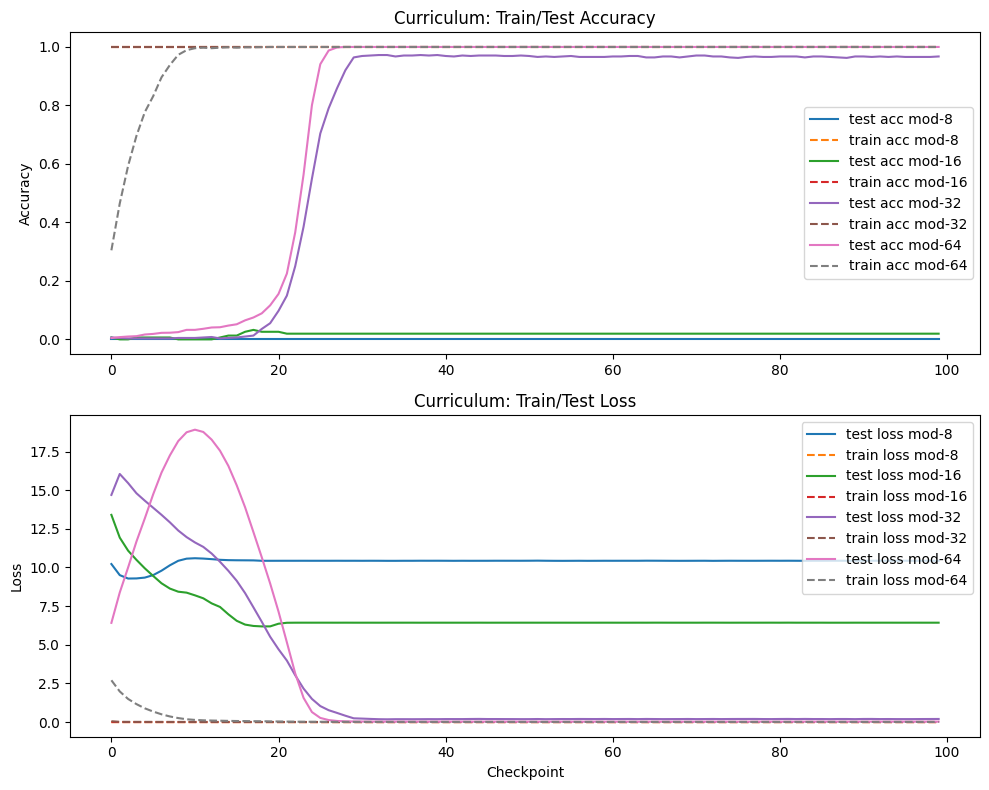

Saved: direct_train_test_accuracy_loss.png


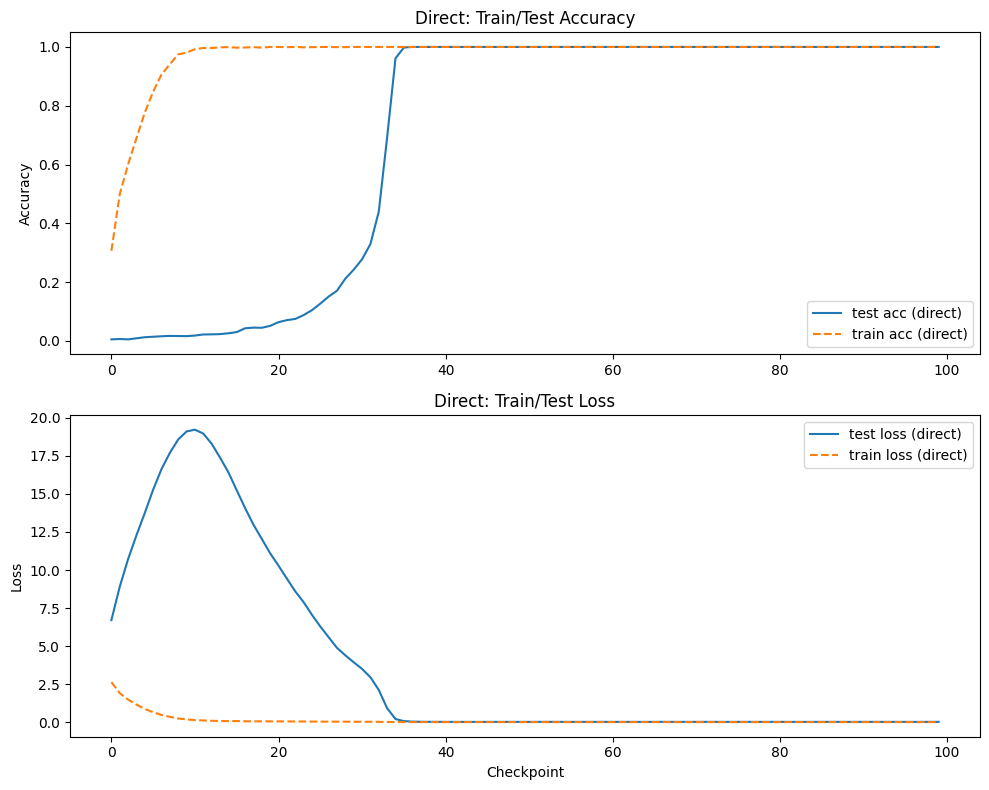

Saved: curriculum_vs_direct_accuracy.png


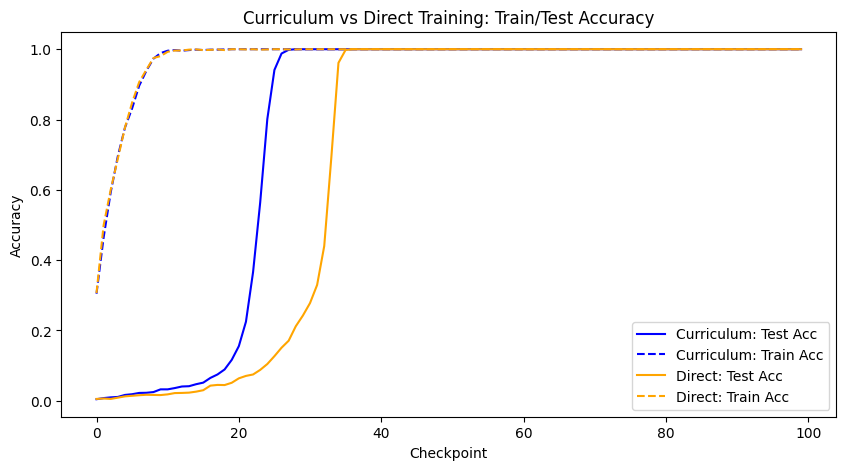

Saved: curriculum_vs_direct_loss.png


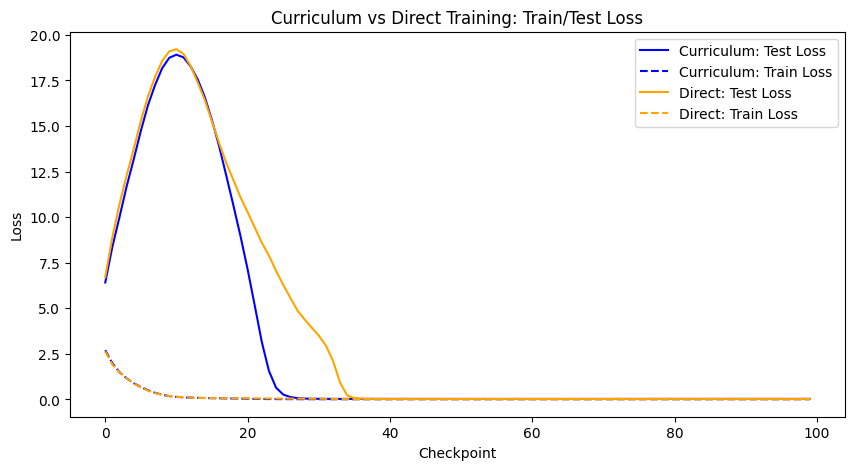

In [25]:
# Plot curriculum accuracy/loss
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
for i, (df, p) in enumerate(zip(curriculum_dfs, CURRICULUM_NUMS)):
    axs[0].plot(df["val_acc"], label=f"test acc mod-{p}")
    axs[0].plot(df["train_acc"], label=f"train acc mod-{p}", linestyle='--')
    axs[1].plot(df["val_loss"], label=f"test loss mod-{p}")
    axs[1].plot(df["train_loss"], label=f"train loss mod-{p}", linestyle='--')
axs[0].set_ylabel("Accuracy")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Checkpoint")
axs[0].legend()
axs[1].legend()
axs[0].set_title("Curriculum: Train/Test Accuracy")
axs[1].set_title("Curriculum: Train/Test Loss")
plt.tight_layout()
save_and_show(fig, "curriculum_train_test_accuracy_loss.png")

# Plot direct accuracy/loss
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(direct_df["val_acc"], label="test acc (direct)")
axs[0].plot(direct_df["train_acc"], label="train acc (direct)", linestyle='--')
axs[1].plot(direct_df["val_loss"], label="test loss (direct)")
axs[1].plot(direct_df["train_loss"], label="train loss (direct)", linestyle='--')
axs[0].set_ylabel("Accuracy")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Checkpoint")
axs[0].legend()
axs[1].legend()
axs[0].set_title("Direct: Train/Test Accuracy")
axs[1].set_title("Direct: Train/Test Loss")
plt.tight_layout()
save_and_show(fig, "direct_train_test_accuracy_loss.png")

# Plot last checkpoint accuracy trajectory and direct training accuracy comparison
curriculum_final_acc = curriculum_dfs[-1]
plt.figure(figsize=(10, 5))
plt.plot(curriculum_final_acc["val_acc"], label="Curriculum: Test Acc", color='blue')
plt.plot(curriculum_final_acc["train_acc"], label="Curriculum: Train Acc", color='blue', linestyle='--')
plt.plot(direct_df["val_acc"], label="Direct: Test Acc", color='orange')
plt.plot(direct_df["train_acc"], label="Direct: Train Acc", color='orange', linestyle='--')
plt.xlabel("Checkpoint")
plt.ylabel("Accuracy")
plt.title("Curriculum vs Direct Training: Train/Test Accuracy")
plt.legend()
fig = plt.gcf()
save_and_show(fig, "curriculum_vs_direct_accuracy.png")

# do the same for loss (last checkpoint vs. direct)
plt.figure(figsize=(10, 5))
plt.plot(curriculum_final_acc["val_loss"], label="Curriculum: Test Loss", color='blue')
plt.plot(curriculum_final_acc["train_loss"], label="Curriculum: Train Loss", color='blue', linestyle='--')
plt.plot(direct_df["val_loss"], label="Direct: Test Loss", color='orange')
plt.plot(direct_df["train_loss"], label="Direct: Train Loss", color='orange', linestyle='--')
plt.xlabel("Checkpoint")
plt.ylabel("Loss")
plt.title("Curriculum vs Direct Training: Train/Test Loss")
plt.legend()
fig = plt.gcf()
save_and_show(fig, "curriculum_vs_direct_loss.png")

## 7.5 Verify Loss Trace Convergence (LLC Hyperparameter Test)

Before estimating LLC on all checkpoints, verify that the loss trace converges properly with the chosen hyperparameters. This follows the devinterp example pattern.

In [26]:
# LLC hyperparameters (from devinterp example)
lr = 3e-3  # epsilon
nbeta = 2.0
gamma = 5.0  # localization
num_chains = 1  # Use 1 chain for individual checkpoint estimation

# Test on final curriculum checkpoint with more draws to verify convergence
print("Testing LLC estimation on final curriculum checkpoint (mod-64)...")
final_params = ExperimentParams()
final_params.p = CURRICULUM_NUMS[-1]
train_data, _ = curriculum_splits[CURRICULUM_NUMS[-1]]
loader = DataLoader(train_data, batch_size=final_params.batch_size, shuffle=True)

test_llc_stats = estimate_learning_coeff_with_summary(
    curriculum_checkpoints[-1][-1],  # Last checkpoint of last stage
    loader=loader,
    evaluate=evaluate_ce,
    sampling_method=SGLD,
    optimizer_kwargs=dict(lr=lr, nbeta=nbeta, localization=gamma),
    num_chains=3,  # Use more chains for verification
    num_draws=1500,  # Use more draws to check convergence
    device=DEVICE,
    online=True,  # Use online=True to get loss/trace for visualization
)
print(f"Keys returned: {test_llc_stats.keys()}")

Testing LLC estimation on final curriculum checkpoint (mod-64)...


Chain 2: 100%|██████████| 1500/1500 [00:01<00:00, 857.27it/s]

Keys returned: dict_keys(['init_loss', 'llc/means', 'llc/stds', 'llc/trace', 'loss/trace'])


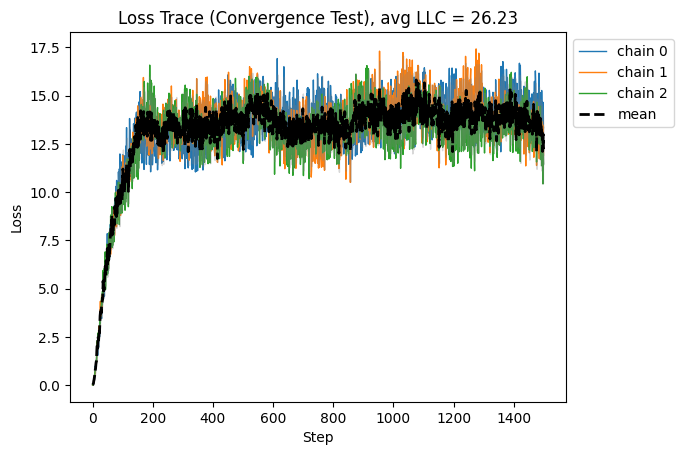

<Figure size 1200x600 with 0 Axes>


Average LLC from 1500 chains: 26.23
If the loss trace flattens out, the hyperparameters are good for LLC estimation.


In [27]:
# Plot loss trace to verify convergence
from devinterp.utils import plot_trace

trace = test_llc_stats["loss/trace"]
avg_llc = sum(test_llc_stats['llc/means']) / len(test_llc_stats['llc/means'])

plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace (Convergence Test), avg LLC = {avg_llc:.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 6),
    true_lc=None,
)

print(f"\nAverage LLC from {len(test_llc_stats['llc/means'])} chains: {avg_llc:.2f}")
print("If the loss trace flattens out, the hyperparameters are good for LLC estimation.")

## 8. Estimate LLC for All Curriculum Checkpoints

Estimate the Local Learning Coefficient (LLC) for every checkpoint across all curriculum stages using the devinterp SGLD-based estimator. This will show how model complexity evolves during each training stage.

In [28]:
num_draws = 1000


# Estimate LLC for ALL checkpoints in each curriculum stage
# Note: Use online=False to get 'llc/mean' (single value) instead of 'llc/means' (array per chain)
print("\n" + "="*80)
print("Estimating LLC for all curriculum checkpoints...")
print("="*80)

curriculum_llcs_by_stage = []

for stage_idx, (checkpoints, p) in enumerate(zip(curriculum_checkpoints, CURRICULUM_NUMS)):
    print(f"\nStage {stage_idx+1}/{len(CURRICULUM_NUMS)}: mod-{p}")
    print(f"  Estimating LLC for {len(checkpoints)} checkpoints...")
    
    params = ExperimentParams()
    params.p = p
    train_data, _ = curriculum_splits[p]
    loader = DataLoader(train_data, batch_size=params.batch_size, shuffle=True)
    
    stage_llcs = []
    for checkpoint_idx, model_checkpoint in enumerate(checkpoints):
        if (checkpoint_idx + 1) % 20 == 0 or checkpoint_idx == 0 or checkpoint_idx == len(checkpoints) - 1:
            print(f"    Checkpoint {checkpoint_idx+1}/{len(checkpoints)}")
        
        llc_stats = estimate_learning_coeff_with_summary(
            model_checkpoint,
            loader=loader,
            evaluate=evaluate_ce,
            sampling_method=SGLD,
            optimizer_kwargs=dict(lr=lr, nbeta=nbeta, localization=gamma),
            num_chains=num_chains,
            num_draws=num_draws,
            device=DEVICE,
            online=False,  # Use online=False to get 'llc/mean' instead of 'llc/means'
        )
        stage_llcs.append(llc_stats)
    
    curriculum_llcs_by_stage.append(stage_llcs)
    print(f"  Completed mod-{p}: LLC range [{min(llc['llc/mean'] for llc in stage_llcs):.2f}, {max(llc['llc/mean'] for llc in stage_llcs):.2f}]")

print("\n" + "="*80)
print("Curriculum LLC estimation complete!")
print("="*80)


Estimating LLC for all curriculum checkpoints...

Stage 1/4: mod-8
  Estimating LLC for 100 checkpoints...
    Checkpoint 1/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 999.57it/s]


    Checkpoint 20/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 768.90it/s]


    Checkpoint 40/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 845.09it/s]


    Checkpoint 60/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 786.43it/s]


    Checkpoint 80/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 872.00it/s]


    Checkpoint 100/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 881.73it/s]


  Completed mod-8: LLC range [3.97, 7.48]

Stage 2/4: mod-16
  Estimating LLC for 100 checkpoints...
    Checkpoint 1/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 845.49it/s]


    Checkpoint 20/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 850.06it/s]


    Checkpoint 40/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 746.17it/s]


    Checkpoint 60/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 790.60it/s]


    Checkpoint 80/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 821.65it/s]


    Checkpoint 100/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 806.92it/s]


  Completed mod-16: LLC range [11.47, 16.12]

Stage 3/4: mod-32
  Estimating LLC for 100 checkpoints...
    Checkpoint 1/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 861.43it/s]


    Checkpoint 20/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 882.64it/s]


    Checkpoint 40/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 857.74it/s]


    Checkpoint 60/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 855.18it/s]


    Checkpoint 80/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 802.62it/s]


    Checkpoint 100/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 847.13it/s]


  Completed mod-32: LLC range [17.81, 35.26]

Stage 4/4: mod-64
  Estimating LLC for 100 checkpoints...
    Checkpoint 1/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 765.91it/s]


    Checkpoint 20/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 820.33it/s]


    Checkpoint 40/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 855.66it/s]


    Checkpoint 60/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 860.80it/s]


    Checkpoint 80/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 769.40it/s]


    Checkpoint 100/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 814.18it/s]

  Completed mod-64: LLC range [24.68, 52.32]

Curriculum LLC estimation complete!


## 9. Estimate LLC for All Direct Training Checkpoints

Estimate the LLC for every checkpoint in the direct training trajectory. This provides a baseline to compare against curriculum learning.

In [29]:
# Estimate LLC for ALL checkpoints in direct training
print("\n" + "="*80)
print(f"Estimating LLC for direct training checkpoints (mod-{DIRECT_NUMS})...")
print("="*80)
print(f"Total checkpoints: {len(direct_checkpoints)}")

loader = DataLoader(direct_train_data, batch_size=direct_params.batch_size, shuffle=True)

direct_llcs = []
for i, model_checkpoint in enumerate(direct_checkpoints):
    if (i + 1) % 20 == 0 or i == 0 or i == len(direct_checkpoints) - 1:
        print(f"  Checkpoint {i+1}/{len(direct_checkpoints)}")
    
    llc_stats = estimate_learning_coeff_with_summary(
        model_checkpoint,
        loader=loader,
        evaluate=evaluate_ce,
        sampling_method=SGLD,
        optimizer_kwargs=dict(lr=lr, nbeta=nbeta, localization=gamma),
        num_chains=num_chains,
        num_draws=num_draws,
        device=DEVICE,
        online=False,  # Use online=False to get 'llc/mean' instead of 'llc/means'
    )
    direct_llcs.append(llc_stats)

print(f"\nCompleted! LLC range: [{min(llc['llc/mean'] for llc in direct_llcs):.2f}, {max(llc['llc/mean'] for llc in direct_llcs):.2f}]")
print("="*80)


Estimating LLC for direct training checkpoints (mod-64)...
Total checkpoints: 100
  Checkpoint 1/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 772.20it/s]


  Checkpoint 20/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 844.60it/s]


  Checkpoint 40/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 819.93it/s]


  Checkpoint 60/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 768.59it/s]


  Checkpoint 80/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 823.01it/s]


  Checkpoint 100/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 821.60it/s]


Completed! LLC range: [25.00, 51.87]


## 10. Plot LLC Trajectories and Comparisons

Plot LLC estimates across all curriculum stages and direct training checkpoints. Compare the evolution of LLC alongside accuracy and loss to understand how model complexity (measured by LLC) relates to grokking behavior.

Saved: curriculum_llc_vs_accuracy.png


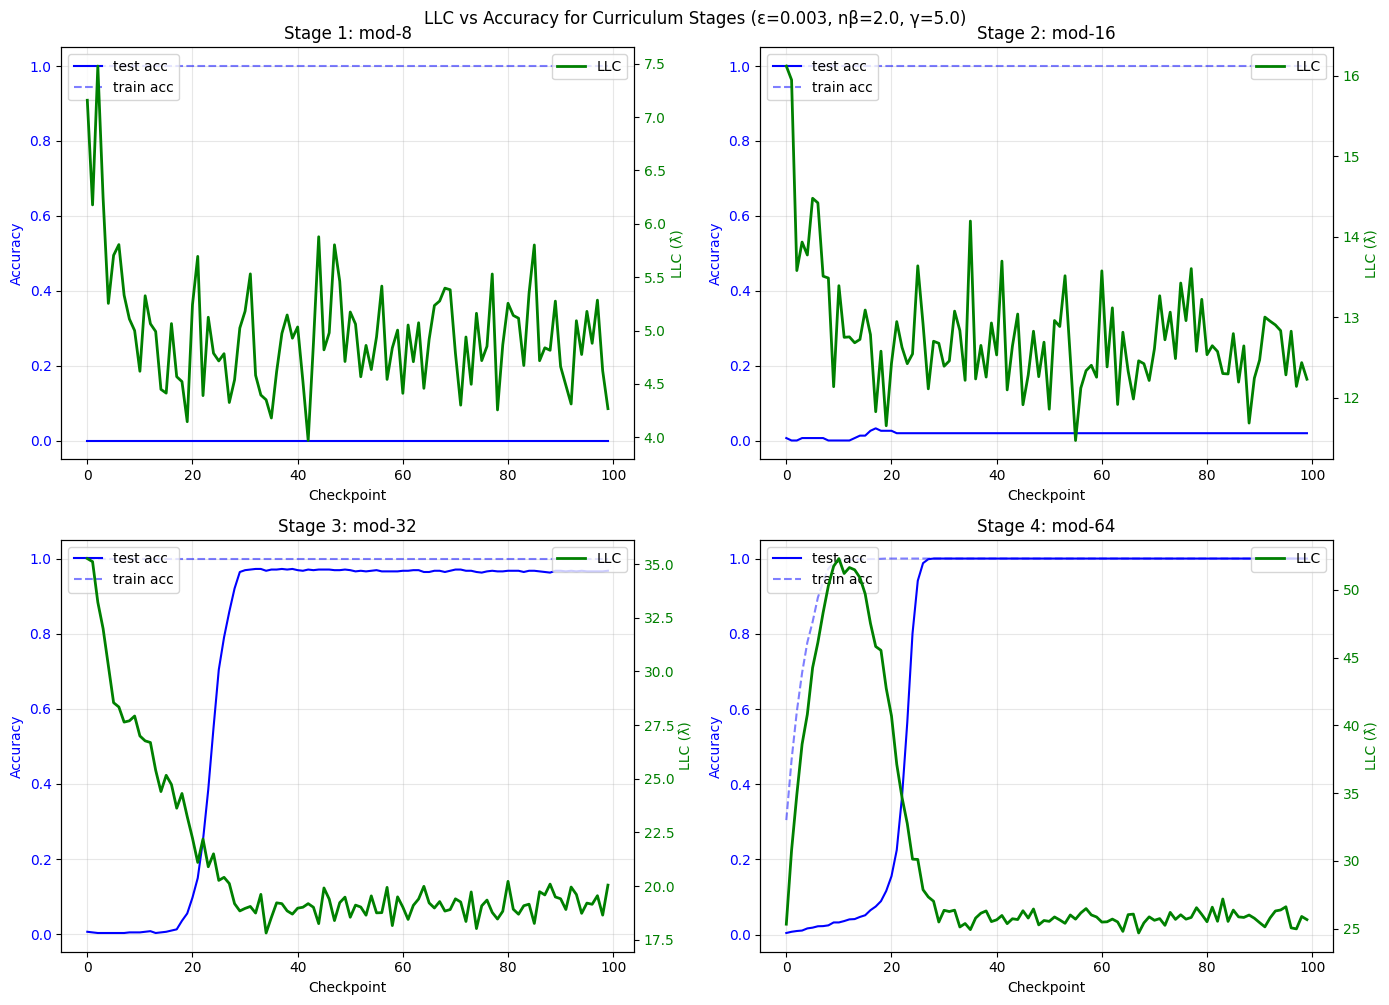

Saved: curriculum_llc_vs_loss.png


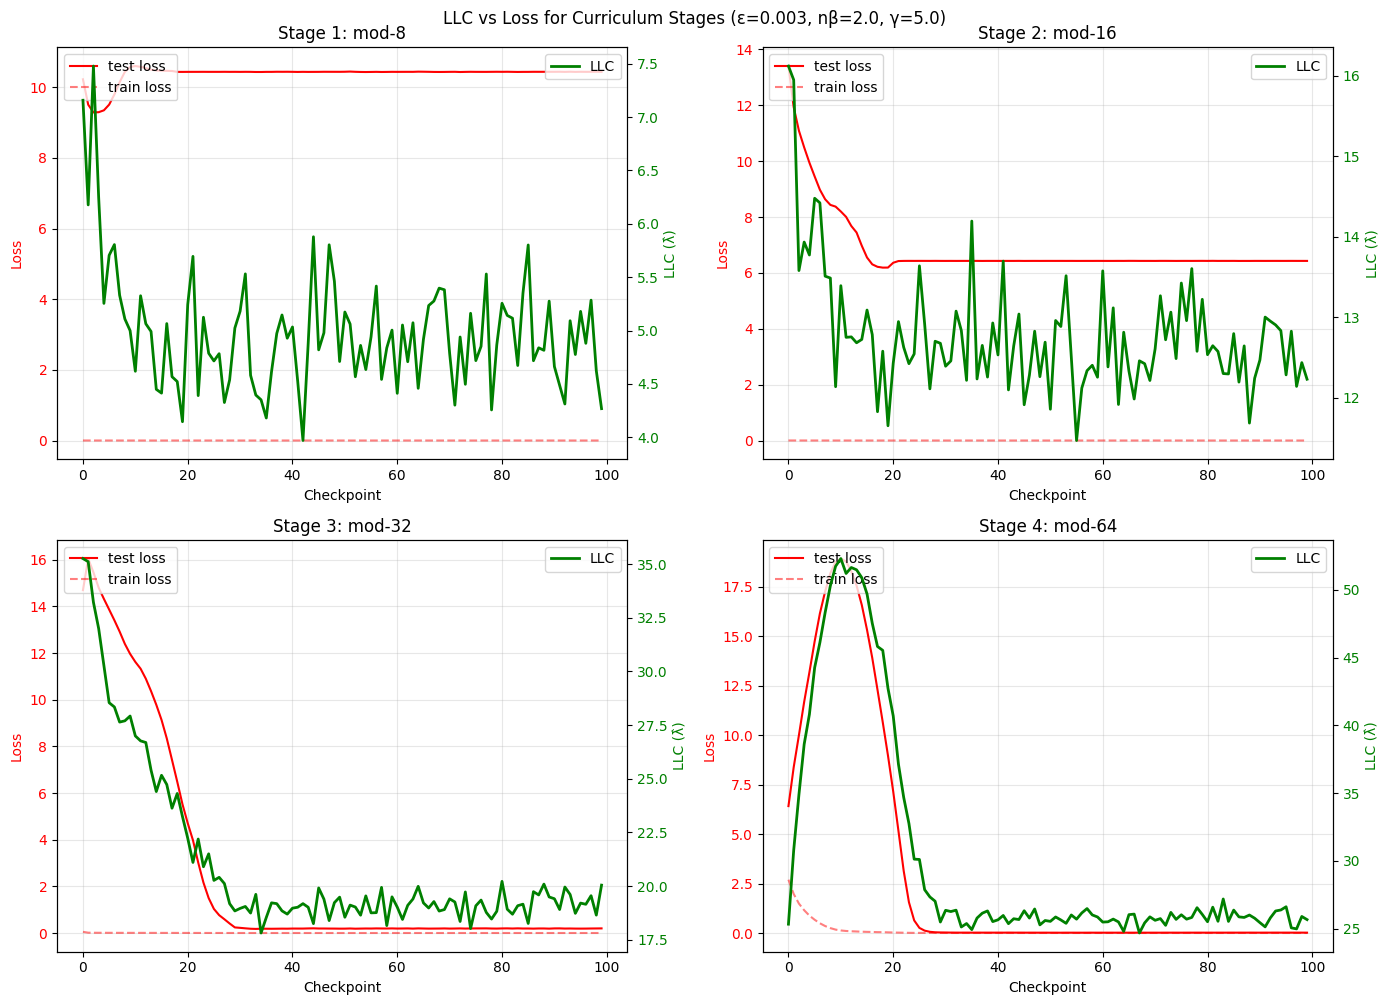

In [30]:
# Plot LLC trajectories for each curriculum stage (separate plots)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for stage_idx, (stage_llcs, df, p) in enumerate(zip(curriculum_llcs_by_stage, curriculum_dfs, CURRICULUM_NUMS)):
    ax1 = axes[stage_idx]
    ax2 = ax1.twinx()
    
    # Plot accuracy
    ax1.plot(df["val_acc"], label="test acc", color='blue')
    ax1.plot(df["train_acc"], label="train acc", color='blue', linestyle='--', alpha=0.5)
    
    # Plot LLC
    ax2.plot([llc["llc/mean"] for llc in stage_llcs], color='green', label="LLC", linewidth=2)
    
    ax1.set_xlabel("Checkpoint")
    ax1.set_ylabel("Accuracy", color='blue')
    ax2.set_ylabel("LLC (λ̂)", color='green')
    ax1.set_title(f"Stage {stage_idx+1}: mod-{p}")
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='green')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle(f"LLC vs Accuracy for Curriculum Stages (ε={lr}, nβ={nbeta}, γ={gamma})", y=1.00)
save_and_show(fig, "curriculum_llc_vs_accuracy.png")

# Plot LLC vs loss for each curriculum stage
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for stage_idx, (stage_llcs, df, p) in enumerate(zip(curriculum_llcs_by_stage, curriculum_dfs, CURRICULUM_NUMS)):
    ax1 = axes[stage_idx]
    ax2 = ax1.twinx()
    
    # Plot loss
    ax1.plot(df["val_loss"], label="test loss", color='red')
    ax1.plot(df["train_loss"], label="train loss", color='red', linestyle='--', alpha=0.5)
    
    # Plot LLC
    ax2.plot([llc["llc/mean"] for llc in stage_llcs], color='green', label="LLC", linewidth=2)
    
    ax1.set_xlabel("Checkpoint")
    ax1.set_ylabel("Loss", color='red')
    ax2.set_ylabel("LLC (λ̂)", color='green')
    ax1.set_title(f"Stage {stage_idx+1}: mod-{p}")
    ax1.tick_params(axis='y', labelcolor='red')
    ax2.tick_params(axis='y', labelcolor='green')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle(f"LLC vs Loss for Curriculum Stages (ε={lr}, nβ={nbeta}, γ={gamma})", y=1.00)
save_and_show(fig, "curriculum_llc_vs_loss.png")

Saved: direct_llc_vs_accuracy.png


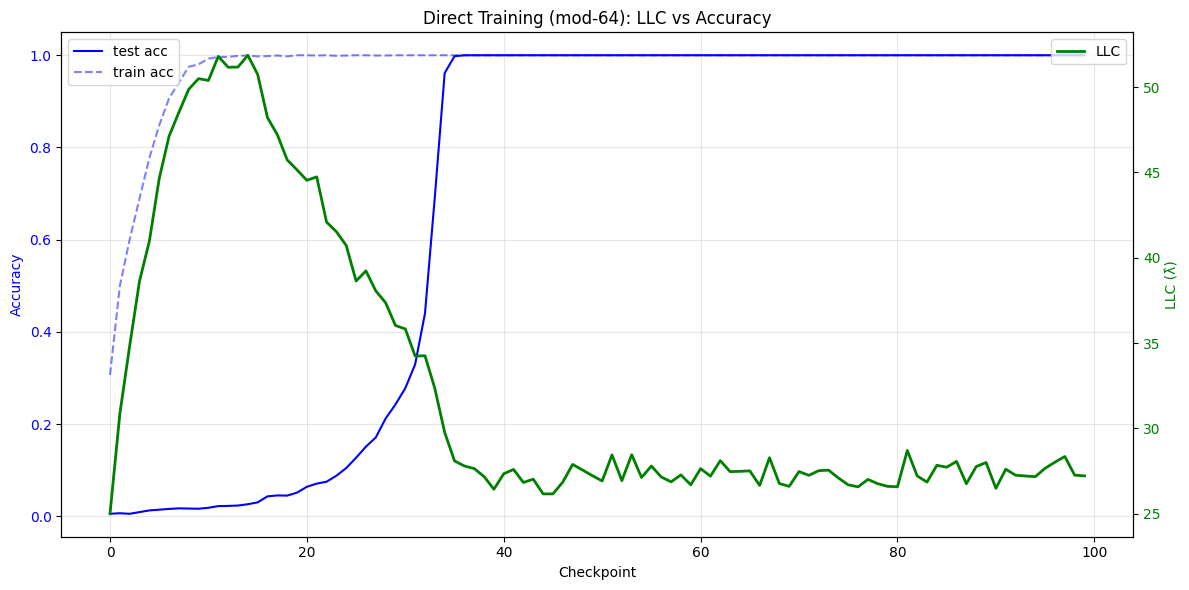

Saved: direct_llc_vs_loss.png


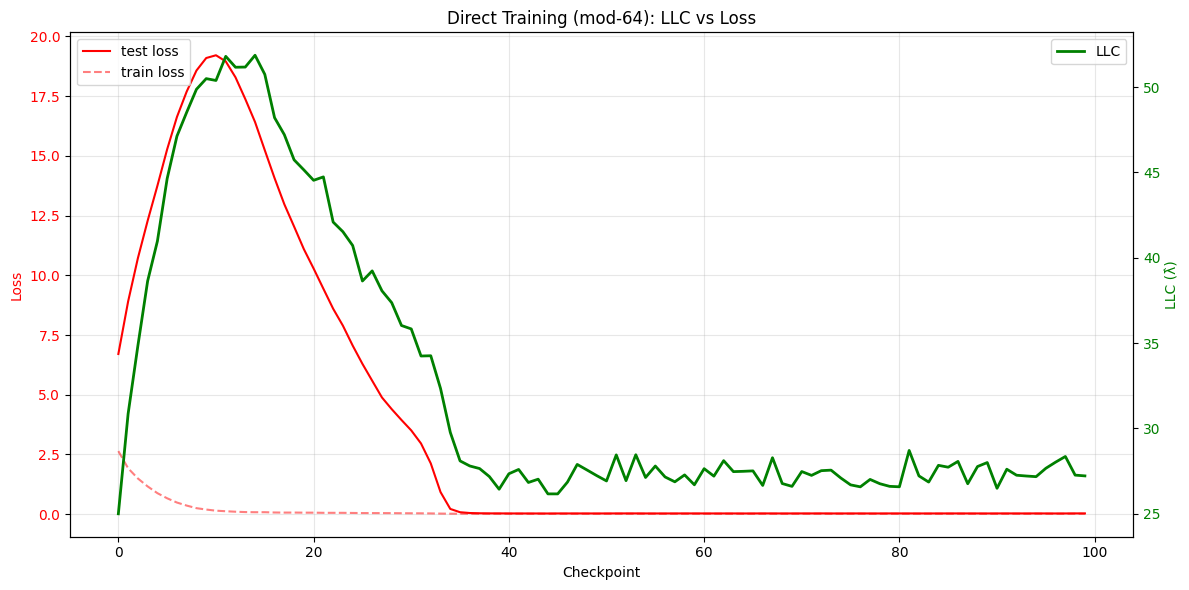

In [31]:
# Plot direct training: LLC vs Accuracy
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.plot(direct_df["val_acc"], label="test acc", color='blue')
ax1.plot(direct_df["train_acc"], label="train acc", color='blue', linestyle='--', alpha=0.5)
ax2.plot([llc["llc/mean"] for llc in direct_llcs], color='green', label="LLC", linewidth=2)

ax1.set_xlabel("Checkpoint")
ax1.set_ylabel("Accuracy", color='blue')
ax2.set_ylabel("LLC (λ̂)", color='green')
ax1.set_title(f"Direct Training (mod-{DIRECT_NUMS}): LLC vs Accuracy")
ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='green')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
plt.tight_layout()
save_and_show(fig, "direct_llc_vs_accuracy.png")

# Plot direct training: LLC vs Loss
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.plot(direct_df["val_loss"], label="test loss", color='red')
ax1.plot(direct_df["train_loss"], label="train loss", color='red', linestyle='--', alpha=0.5)
ax2.plot([llc["llc/mean"] for llc in direct_llcs], color='green', label="LLC", linewidth=2)

ax1.set_xlabel("Checkpoint")
ax1.set_ylabel("Loss", color='red')
ax2.set_ylabel("LLC (λ̂)", color='green')
ax1.set_title(f"Direct Training (mod-{DIRECT_NUMS}): LLC vs Loss")
ax1.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='y', labelcolor='green')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
plt.tight_layout()
save_and_show(fig, "direct_llc_vs_loss.png")

Saved: curriculum_vs_direct_llc_vs_accuracy.png


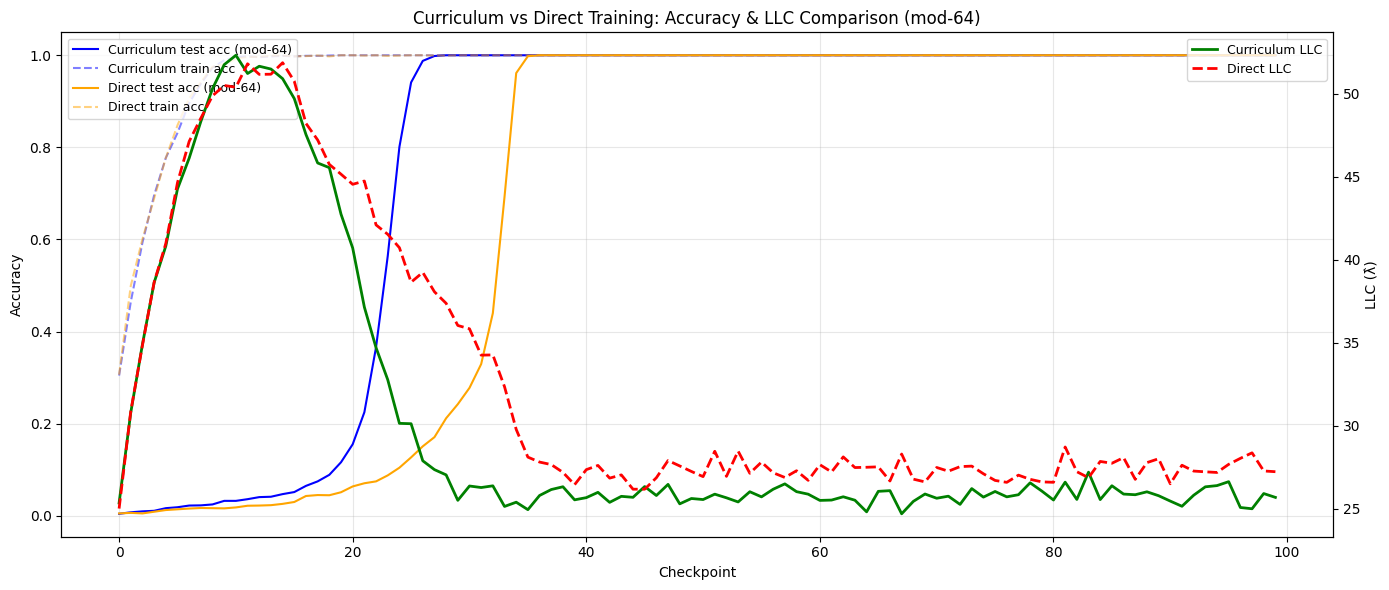

Saved: curriculum_vs_direct_llc_vs_loss.png


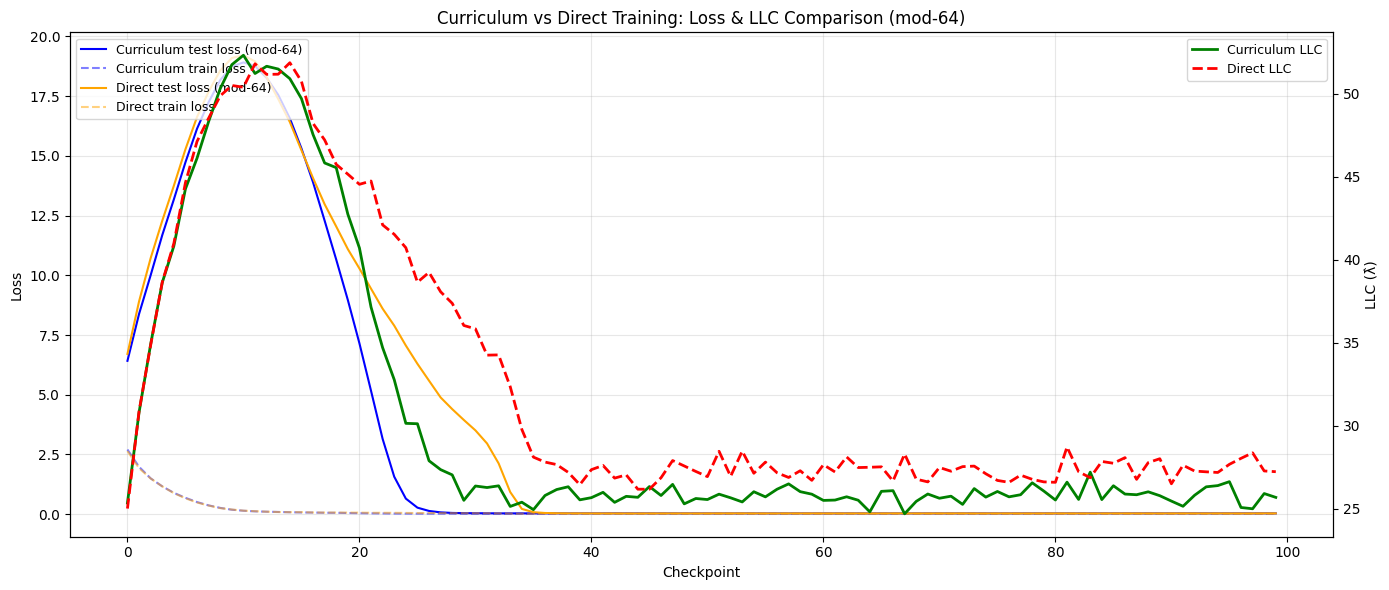

In [32]:
# Comparison: Curriculum final stage vs Direct training (LLC vs Accuracy)
fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()

# Curriculum final stage
curriculum_final_llcs = curriculum_llcs_by_stage[-1]
curriculum_final_df = curriculum_dfs[-1]

ax1.plot(curriculum_final_df["val_acc"], label=f"Curriculum test acc (mod-{CURRICULUM_NUMS[-1]})", color='blue')
ax1.plot(curriculum_final_df["train_acc"], label=f"Curriculum train acc", color='blue', linestyle='--', alpha=0.5)

# Direct training
ax1.plot(direct_df["val_acc"], label=f"Direct test acc (mod-{DIRECT_NUMS})", color='orange')
ax1.plot(direct_df["train_acc"], label=f"Direct train acc", color='orange', linestyle='--', alpha=0.5)

# LLC overlay
ax2.plot([llc["llc/mean"] for llc in curriculum_final_llcs], color='green', label="Curriculum LLC", linewidth=2)
ax2.plot([llc["llc/mean"] for llc in direct_llcs], color='red', label="Direct LLC", linewidth=2, linestyle='--')

ax1.set_xlabel("Checkpoint")
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("LLC (λ̂)")
ax1.set_title(f"Curriculum vs Direct Training: Accuracy & LLC Comparison (mod-{DIRECT_NUMS})")
ax1.legend(loc='upper left', fontsize=9)
ax2.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)
plt.tight_layout()
save_and_show(fig, "curriculum_vs_direct_llc_vs_accuracy.png")

# Comparison: Curriculum final stage vs Direct training (LLC vs Loss)  
fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()

# Loss curves
ax1.plot(curriculum_final_df["val_loss"], label=f"Curriculum test loss (mod-{CURRICULUM_NUMS[-1]})", color='blue')
ax1.plot(curriculum_final_df["train_loss"], label=f"Curriculum train loss", color='blue', linestyle='--', alpha=0.5)
ax1.plot(direct_df["val_loss"], label=f"Direct test loss (mod-{DIRECT_NUMS})", color='orange')
ax1.plot(direct_df["train_loss"], label=f"Direct train loss", color='orange', linestyle='--', alpha=0.5)

# LLC overlay
ax2.plot([llc["llc/mean"] for llc in curriculum_final_llcs], color='green', label="Curriculum LLC", linewidth=2)
ax2.plot([llc["llc/mean"] for llc in direct_llcs], color='red', label="Direct LLC", linewidth=2, linestyle='--')

ax1.set_xlabel("Checkpoint")
ax1.set_ylabel("Loss")
ax2.set_ylabel("LLC (λ̂)")
ax1.set_title(f"Curriculum vs Direct Training: Loss & LLC Comparison (mod-{DIRECT_NUMS})")
ax1.legend(loc='upper left', fontsize=9)
ax2.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)
plt.tight_layout()
save_and_show(fig, "curriculum_vs_direct_llc_vs_loss.png")

Saved: llc_trajectories_comparison.png


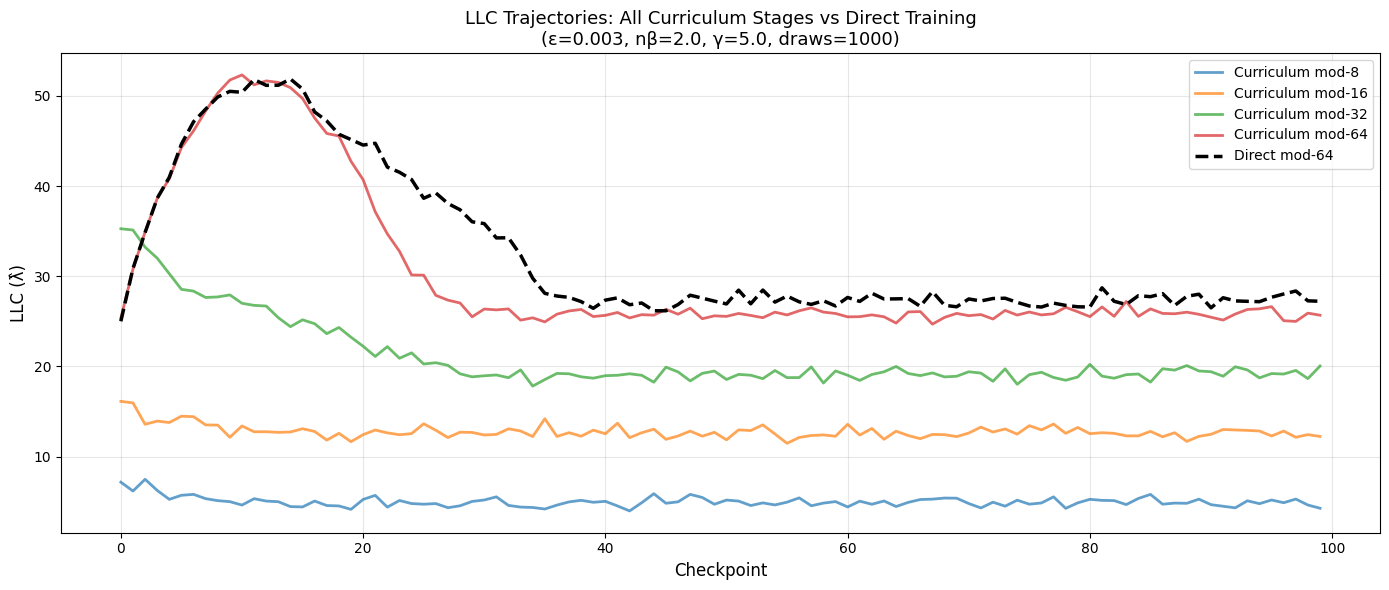


SUMMARY: LLC Statistics

Curriculum Stage 1 (mod-8):
  Initial LLC: 7.16
  Final LLC:   4.27
  Min LLC:     3.97
  Max LLC:     7.48

Curriculum Stage 2 (mod-16):
  Initial LLC: 16.12
  Final LLC:   12.23
  Min LLC:     11.47
  Max LLC:     16.12

Curriculum Stage 3 (mod-32):
  Initial LLC: 35.26
  Final LLC:   20.04
  Min LLC:     17.81
  Max LLC:     35.26

Curriculum Stage 4 (mod-64):
  Initial LLC: 25.34
  Final LLC:   25.67
  Min LLC:     24.68
  Max LLC:     52.32

Direct Training (mod-64):
  Initial LLC: 25.00
  Final LLC:   27.22
  Min LLC:     25.00
  Max LLC:     51.87


In [33]:
# Plot LLC trajectories only (for clearer comparison)
fig = plt.figure(figsize=(14, 6))

# Plot each curriculum stage
for stage_idx, (stage_llcs, p) in enumerate(zip(curriculum_llcs_by_stage, CURRICULUM_NUMS)):
    plt.plot([llc["llc/mean"] for llc in stage_llcs], 
             label=f"Curriculum mod-{p}", 
             linewidth=2,
             alpha=0.7)

# Plot direct training
plt.plot([llc["llc/mean"] for llc in direct_llcs], 
         label=f"Direct mod-{DIRECT_NUMS}", 
         linewidth=2.5,
         linestyle='--',
         color='black')

plt.xlabel("Checkpoint", fontsize=12)
plt.ylabel("LLC (λ̂)", fontsize=12)
plt.title(f"LLC Trajectories: All Curriculum Stages vs Direct Training\n(ε={lr}, nβ={nbeta}, γ={gamma}, draws={num_draws})", fontsize=13)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
save_and_show(fig, "llc_trajectories_comparison.png")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY: LLC Statistics")
print("="*80)
for stage_idx, (stage_llcs, p) in enumerate(zip(curriculum_llcs_by_stage, CURRICULUM_NUMS)):
    llc_values = [llc["llc/mean"] for llc in stage_llcs]
    print(f"\nCurriculum Stage {stage_idx+1} (mod-{p}):")
    print(f"  Initial LLC: {llc_values[0]:.2f}")
    print(f"  Final LLC:   {llc_values[-1]:.2f}")
    print(f"  Min LLC:     {min(llc_values):.2f}")
    print(f"  Max LLC:     {max(llc_values):.2f}")

direct_llc_values = [llc["llc/mean"] for llc in direct_llcs]
print(f"\nDirect Training (mod-{DIRECT_NUMS}):")
print(f"  Initial LLC: {direct_llc_values[0]:.2f}")
print(f"  Final LLC:   {direct_llc_values[-1]:.2f}")
print(f"  Min LLC:     {min(direct_llc_values):.2f}")
print(f"  Max LLC:     {max(direct_llc_values):.2f}")
print("="*80)